# Gesture Recognition Intro


## Goals

*   Pre-process and visualize data
*   Train model to predict the gesture
*   Test model predictor
*   Export model to be used in live gesture recognition
*   Feature evaluation for future iterations



This notebook will be using the RaspberryPi 5 with the Freenove Accelerometer MP6600.

# Load Data & Pre-process

## Imports

In [ ]:
# Load the data
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [ ]:
def load_trial_data(file_path):
    df = pd.read_csv(file_path)
    features = {}
    for axis in ['x', 'y', 'z', 'mag']:
        features[f'{axis}_mean'] = df[axis].mean()
        features[f'{axis}_std'] = df[axis].std()
        features[f'{axis}_max'] = df[axis].max()
        features[f'{axis}_min'] = df[axis].min()
        features[f'{axis}_kurtosis'] = df[axis].kurtosis()
        features[f'{axis}_skew'] = df[axis].skew()

    return features

Lets visualize the data before we load and train the model.

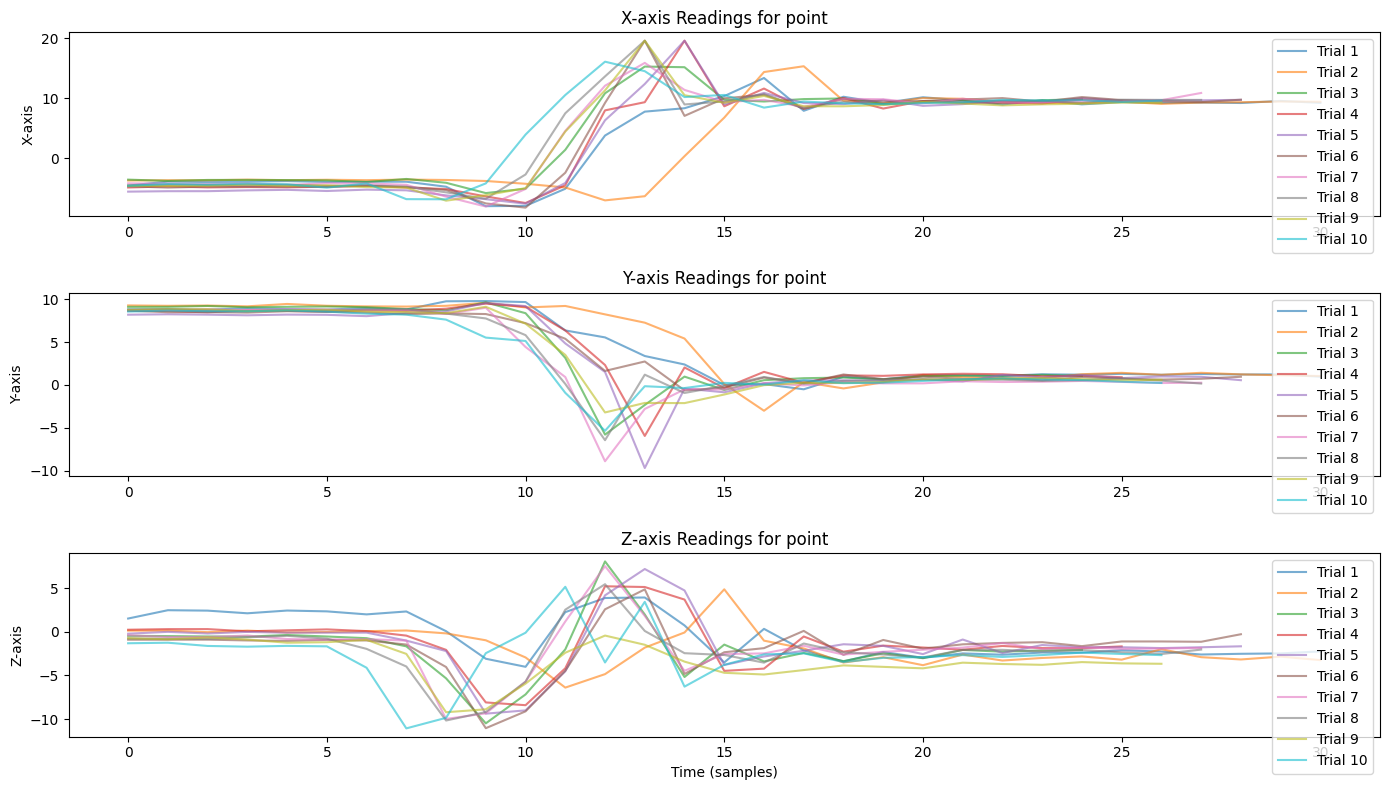

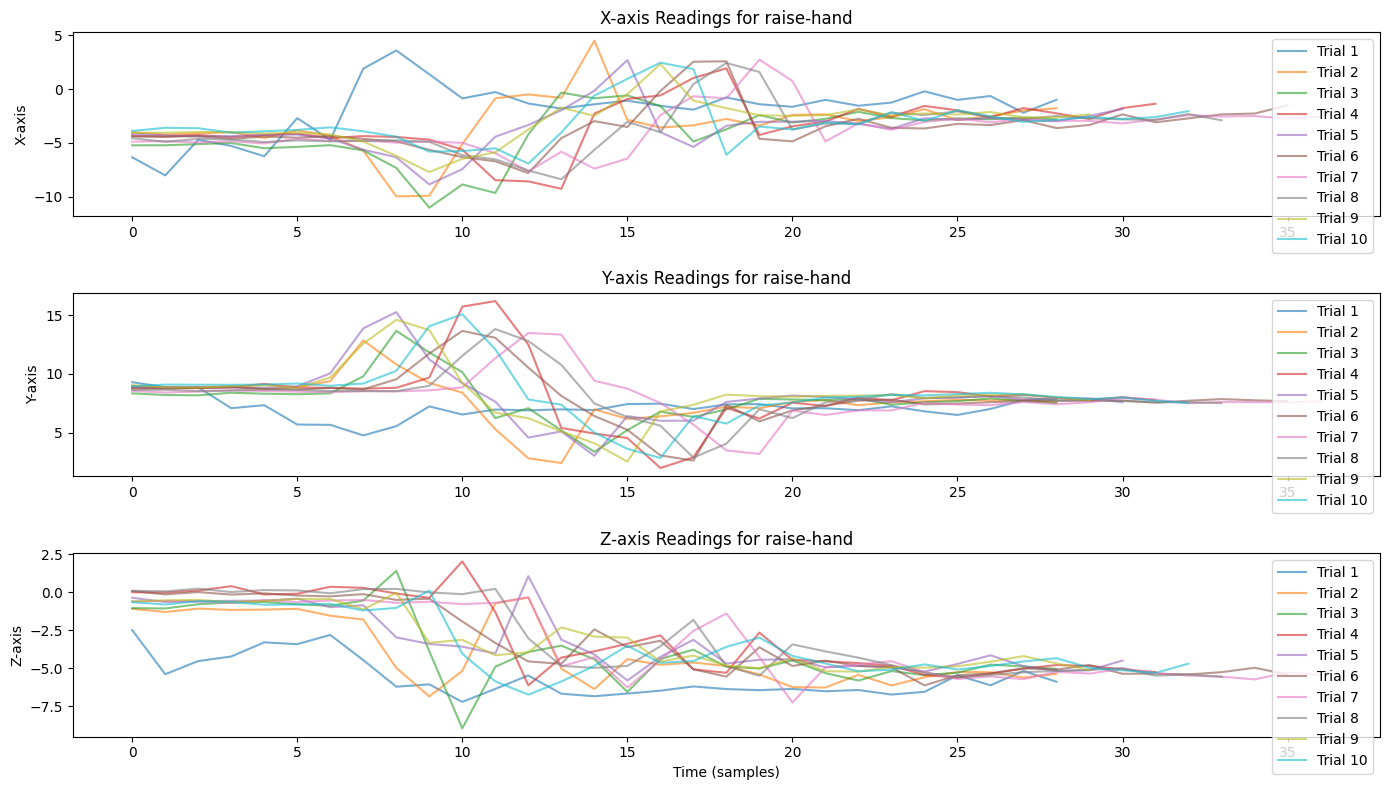

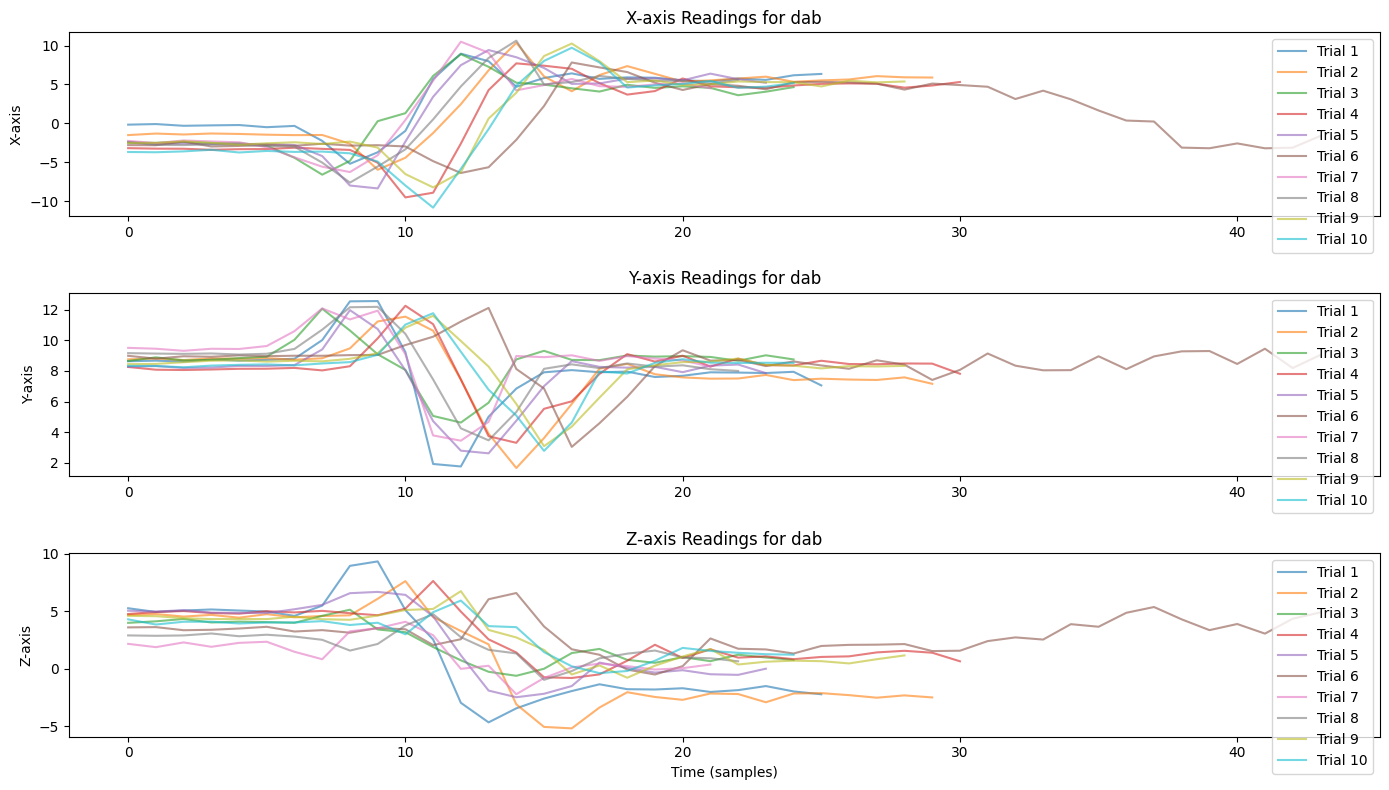

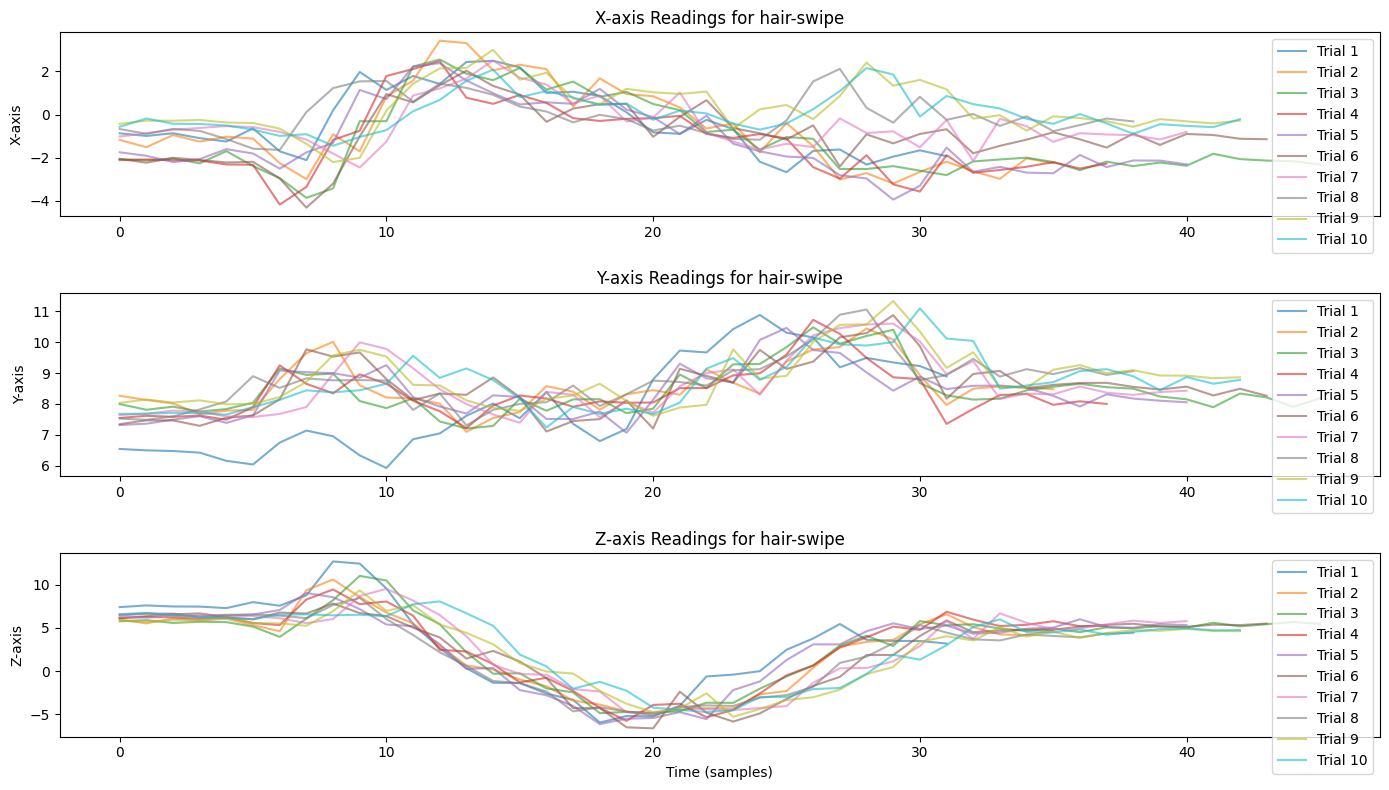

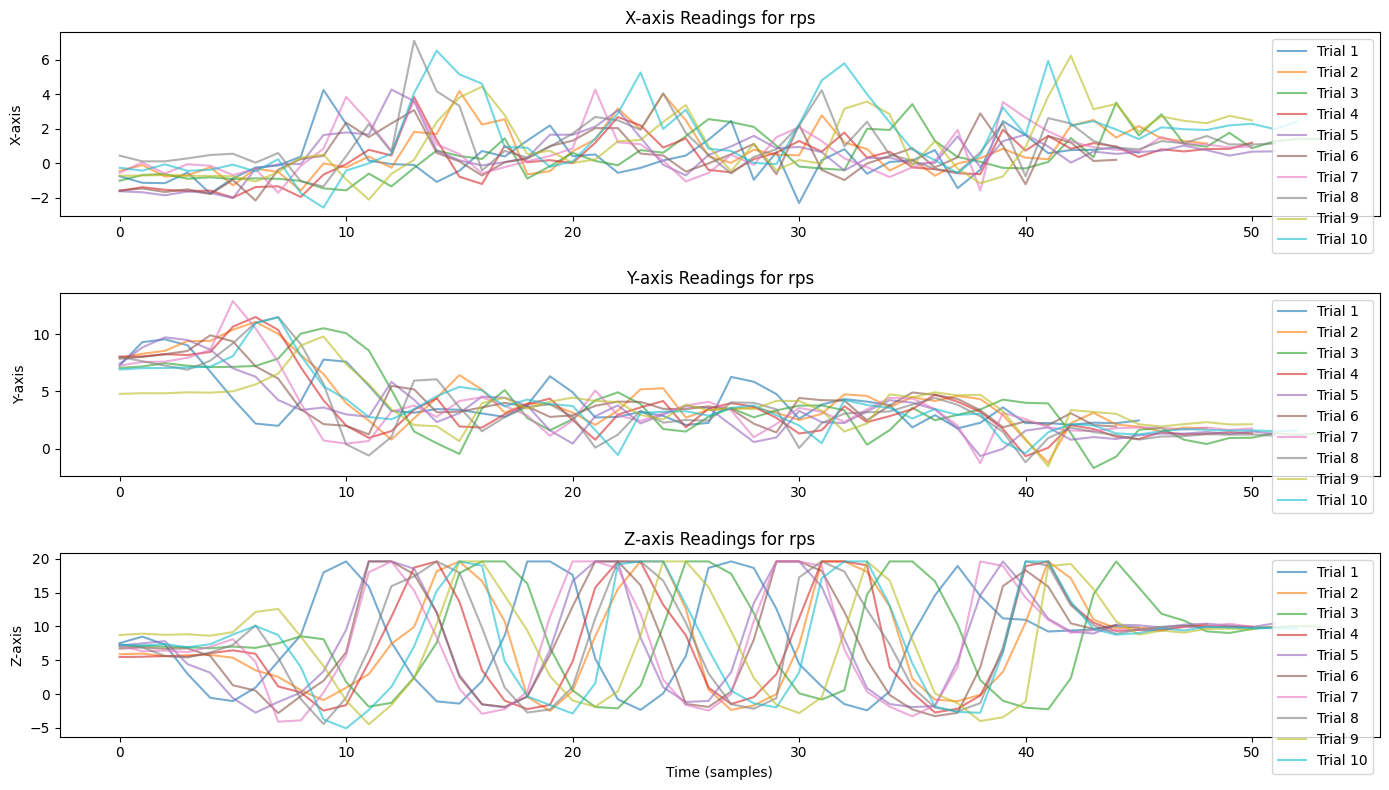

In [ ]:
gestures = ['point', 'raise-hand', 'dab', 'hair-swipe', 'rps']
for gesture in gestures:
  num_trials = 10  # Adjust based on how many trials you have for this gesture
  trials_data = [pd.read_csv(f'data/Johnny/{gesture}_Johnny_{i}_data.csv') for i in range(0, num_trials)]

  # Initialize a plot
  plt.figure(figsize=(14, 8))

  # Plot each trial
  for i, df in enumerate(trials_data, start=1):
      plt.subplot(3, 1, 1)
      plt.plot(df['x'], label=f'Trial {i}', alpha=0.6)  # alpha for transparency
      plt.title(f'X-axis Readings for {gesture}')
      plt.ylabel('X-axis')

      plt.subplot(3, 1, 2)
      plt.plot(df['y'], label=f'Trial {i}', alpha=0.6)
      plt.title(f'Y-axis Readings for {gesture}')
      plt.ylabel('Y-axis')

      plt.subplot(3, 1, 3)
      plt.plot(df['z'], label=f'Trial {i}', alpha=0.6)
      plt.title(f'Z-axis Readings for {gesture}')
      plt.ylabel('Z-axis')
      plt.xlabel('Time (samples)')


  # Add legends to each subplot
  plt.subplot(3, 1, 1)
  plt.legend(loc='upper right')

  plt.subplot(3, 1, 2)
  plt.legend(loc='upper right')

  plt.subplot(3, 1, 3)
  plt.legend(loc='upper right')

  # Adjust layout to prevent overlap
  plt.tight_layout()

  # Show the plot
  plt.show()

## Model Training

Load in all of the trials and data and get the feature sets from each.

In [ ]:
gestures = ['point', 'raise-hand', 'dab', 'hair-swipe', 'rps']
trial_data = []

for gesture in gestures:
    for trial_num in range(0, 10):  # Assuming 10 trials per gesture
        file_path = f'data/Johnny/{gesture}_Johnny_{trial_num}_data.csv'
        features = load_trial_data(file_path)
        features['gesture'] = gesture
        trial_data.append(features)

# Convert to DataFrame
data = pd.DataFrame(trial_data)
data.head()

,x_mean,x_std,x_max,x_min,x_kurtosis,x_skew,y_mean,y_std,y_max,y_min,...,z_min,z_kurtosis,z_skew,mag_mean,mag_std,mag_max,mag_min,mag_kurtosis,mag_skew,gesture
0,3.780676,7.110589,13.393164,-7.965509,-1.678543,-0.439628,4.260134,3.904579,9.804256,-0.505177,...,-4.007894,-1.525081,0.373688,10.054911,1.256923,13.397594,7.760790,2.248133,1.219482,point
1,3.257350,7.260636,15.354015,-7.000646,-1.777822,0.008487,4.575551,4.304578,9.598354,-3.011906,...,-6.385336,2.157325,0.683072,10.251337,1.677295,15.475764,5.435747,5.543147,0.939729,point
2,3.791841,7.446672,15.298949,-5.784391,-1.824585,-0.002435,4.132009,4.717392,9.648633,-5.798756,...,-10.472238,4.303523,0.366477,10.694910,2.498503,16.077810,4.008233,2.308259,0.387161,point
3,3.041350,8.008010,19.612701,-7.436390,-1.475752,0.101502,4.302012,4.324683,9.502586,-5.954380,...,-8.396465,1.147772,-0.167995,10.628277,2.416584,20.058734,8.253091,9.050756,2.777567,point
4,3.589383,8.170203,19.612701,-7.551312,-1.546144,-0.129397,3.374338,4.584635,9.572018,-9.701305,...,-9.363723,2.654158,0.000660,10.669976,2.730934,20.176776,7.740573,5.366338,2.332063,point


Create the model and setup the configuration for training.

In [ ]:
# Prepare features and labels
X = data.drop('gesture', axis=1)
y = data['gesture']

# Setup K-Folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Model selection
model = RandomForestClassifier(n_estimators=100, random_state=42)

Train the model with the split dataset and test it.

In [ ]:
# Training and validation
accuracy_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    print("Fold accuracy:", accuracy)

print("Average accuracy:", np.mean(accuracy_scores))

# Final model training
model.fit(X, y)

Fold accuracy: 1.0
Fold accuracy: 1.0
Fold accuracy: 1.0
Fold accuracy: 1.0
Fold accuracy: 1.0
Average accuracy: 1.0


RandomForestClassifier(random_state=42)

Save the model for later use.

In [ ]:
dump(model, 'gesture_classifier.joblib')

['gesture_classifier.joblib']

## Feature visualization and evaluation


Which features contribute most to the decision-making process in the RandomForest model.

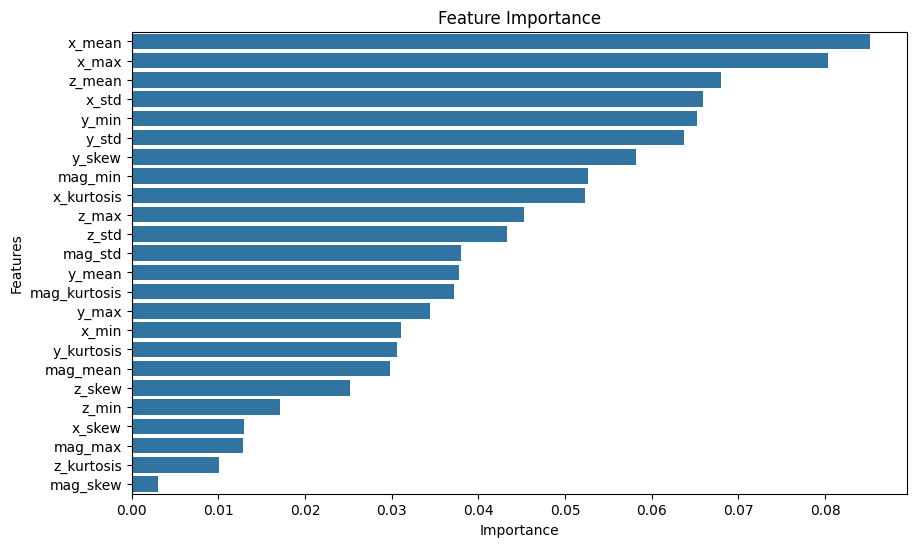

In [ ]:
# Visualize the features within the dataset and how they affect the model
feature_importances = model.feature_importances_

# Create a pandas series to view the feature importances for better visualization
features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=features.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
